In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning import LightningModule, Trainer
import lightning as L
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sb
import os
import pickle as pkl
import numpy as np
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

import pandas as pd
import random

In [22]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [23]:
file = r'.\Dataset\datav1.pkl'
with open(file , 'rb') as f:
    rdata = pkl.load(f)

type(rdata), rdata.shape, rdata.dtype

(torch.Tensor, torch.Size([50000, 256]), torch.float32)

In [24]:
rdata = torch.concat([rdata[::1, :128].unsqueeze(dim=2), rdata[::1, 128:].unsqueeze(dim=2)], dim=2)
rdata.size()

torch.Size([50000, 128, 2])

In [25]:
precision = 32
if precision == 32:
    torch.set_default_dtype(torch.float32)
elif precision == 64:
    torch.set_default_dtype(torch.float64)
    data = rdata.double()

In [26]:
rdatamin = rdata.min()
data = torch.log10(rdata - rdatamin + 1)[::200]
mindata = data.min()
data = (data - data.mean())/data.std()
#data = (data - data.min())/(data.max() - data.min())

In [27]:
class lle_ds(Dataset):
    def __init__(self, data):
        super().__init__()
        self.nst, self.np, self.n = data.size()
        self.np = self.np
        self.slowtimes = torch.linspace(0, 1, self.nst)
        self.phases = torch.linspace(0, 1, self.np)
        self.Xs = torch.stack([self.slowtimes.unsqueeze(1).repeat(1, self.np), 
                         self.phases.unsqueeze(0).repeat(self.nst, 1)], dim=-1)
        self.Xs = self.Xs.reshape(-1, 2)
        self.lle_Ams = data.reshape(-1, 2)

    def __len__(self):
        return self.nst*self.np

    def __getitem__(self, index):
        X = self.Xs[index]
        Am = self.lle_Ams[index]
        return X, Am

In [28]:
class PINN(LightningModule):
    def __init__(self, lr=None, bs=None, 
                 nMLP=None, lMLP=None,
                 loss_fn=None,
                 ):

        super().__init__()
        self.learning_rate = lr
        self.batch_size = bs
        self.save_hyperparameters()
        self.MLP = nn.Sequential(
            nn.Linear(2, nMLP),
            nn.Tanh(),
            nn.Linear(nMLP, nMLP),
            nn.Tanh(),
            nn.Linear(nMLP, int(nMLP/2)),
            nn.Tanh(),
            nn.Linear(int(nMLP/2), 2),
        )
        self.loss_fn = loss_fn

    def forward(self, x):
        MLPout = self.MLP(x)
        #MLPout (bs, sl, freqs)
        return MLPout
    
    def assemble_ds(self, ds):
        trnlen = int(0.9*len(ds))
        print(trnlen)
        self.trnset = ds
        self.valset = ds[trnlen:]
    

    def training_step(self, batch, batch_idx):
        X, Y = batch
        op = self.forward(X)
        loss = self.loss_fn(op, Y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, Y = batch
        op = self.forward(X)
        loss = self.loss_fn(op, Y)
        self.log('val_loss', loss)

    def train_dataloader(self):
        dataloader = DataLoader(self.trnset, batch_size=self.batch_size)
        return dataloader

    def val_dataloader(self):
        dataloader = DataLoader(self.valset, batch_size=self.batch_size)
        return dataloader
    
    def configure_optimizers(self):
        from torch.optim import AdamW, Adam, SGD
        optim = Adam(self.parameters(), lr=self.learning_rate)
        return optim

In [29]:
lr = 1e-3
bs = 1028
nMLP = 32
lMLP = 1
loss_fn = F.mse_loss
epo = 100

ds = lle_ds(data)

In [30]:
save_dir = 'Simple'
name = f'nMLP_{nMLP}'

In [31]:
version = f'v1'
logger = TensorBoardLogger(save_dir, name=name, version=version)
ckpt = ModelCheckpoint(
            os.path.join(save_dir, name, version), monitor='val_loss',
            filename='MLP_epoch_{epoch:03d}_valloss{val_loss:.5f}'
        )
model = PINN(lr, bs, nMLP, lMLP, loss_fn)
model.assemble_ds(ds)

28800


In [32]:
trainer = Trainer(max_epochs=epo, check_val_every_n_epoch=2, callbacks=[ckpt], logger=logger)
trainer.fit(model)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
d:\anaconda\envs\dl\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:652: Checkpoint directory D:\Githome\LLENN\Simple\nMLP_32\v1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | Mode 
--------------------------------------------
0 | MLP  | Sequential | 1.7 K  | train
--------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]

d:\anaconda\envs\dl\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


d:\anaconda\envs\dl\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
d:\anaconda\envs\dl\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:298: The number of training batches (32) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 113.27it/s, v_num=v1]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 32/32 [00:00<00:00, 112.88it/s, v_num=v1]


In [33]:
nst, np, nns = data.size()
slowtimes = torch.linspace(0, 1, nst)
phases = torch.linspace(0, 1, np)

sampling_points = torch.stack([slowtimes.unsqueeze(1).repeat(1, np), 
                         phases.unsqueeze(0).repeat(nst, 1)], dim=-1)
sampling_points = sampling_points.reshape(nst*np, nns)

In [34]:
Amri = model(sampling_points).reshape(nst, np, -1)

<Axes: >

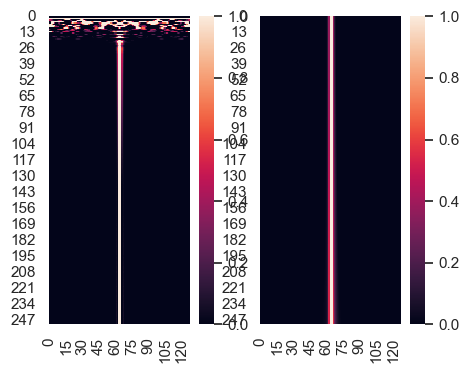

In [35]:
sb.set_theme()
sb.set_style()


fig = plt.figure(figsize=(5, 4))
axi1 = fig.add_subplot(1, 2, 1)
sb.heatmap(data[:, :, 0], ax=axi1, vmin=0, vmax=1)
axi2 = fig.add_subplot(1, 2, 2)
sb.heatmap(Amri[:, :, 0].detach().numpy(), ax=axi2 ,vmin=0, vmax=1)

<Axes: >

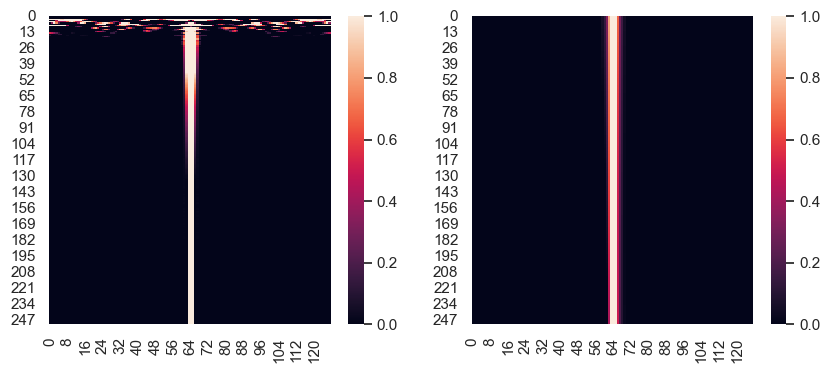

In [36]:
sb.set_theme()
sb.set_style()


fig = plt.figure(figsize=(10, 4))
axi1 = fig.add_subplot(1, 2, 1)
sb.heatmap(data[:, :, 1], ax=axi1, vmin=0, vmax=1)
axi2 = fig.add_subplot(1, 2, 2)
sb.heatmap(Amri[:, :, 1].detach().numpy(), ax=axi2 ,vmin=0, vmax=1)